In [43]:
from google.colab import files
uploaded = files.upload()

Saving dbn.py to dbn.py
Saving t10k-images-idx3-ubyte to t10k-images-idx3-ubyte
Saving t10k-labels-idx1-ubyte to t10k-labels-idx1-ubyte
Saving train-images-idx3-ubyte to train-images-idx3-ubyte
Saving train-labels-idx1-ubyte to train-labels-idx1-ubyte


# util.py

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from sklearn.metrics import mean_squared_error
import os

def sigmoid(support):

    """
    Sigmoid activation function that finds probabilities to turn ON each unit.

    Args:
      support: shape is (size of mini-batch, size of layer)
    Returns:
      on_probabilities: shape is (size of mini-batch, size of layer)
    """

    on_probabilities = 1./(1.+np.exp(-support))
    return on_probabilities

def softmax(support):

    """
    Softmax activation function that finds probabilities of each category

    Args:
      support: shape is (size of mini-batch, number of categories)
    Returns:
      probabilities: shape is (size of mini-batch, number of categories)
    """

    expsup = np.exp(support-np.max(support,axis=1)[:,None])
    return expsup / np.sum(expsup,axis=1)[:,None]

def sample_binary(on_probabilities):

    """
    Sample activations ON=1 (OFF=0) from probabilities sigmoid probabilities

    Args:
      support: shape is (size of mini-batch, size of layer)
    Returns:
      activations: shape is (size of mini-batch, size of layer)
    """

    activations = 1. * ( on_probabilities >= np.random.random_sample(size=on_probabilities.shape) )
    return activations

def sample_categorical(probabilities):

    """
    Sample one-hot activations from categorical probabilities

    Args:
      support: shape is (size of mini-batch, number of categories)
    Returns:
      activations: shape is (size of mini-batch, number of categories)
    """

    cumsum = np.cumsum(probabilities,axis=1)
    rand = np.random.random_sample(size=probabilities.shape[0])[:,None]
    activations = np.zeros(probabilities.shape)
    activations[range(probabilities.shape[0]),np.argmax((cumsum >= rand),axis=1)] = 1
    return activations

def load_idxfile(filename):

    """
    Load idx file format. For more information : http://yann.lecun.com/exdb/mnist/
    """
    import struct

    with open(filename,'rb') as _file:
        if ord(_file.read(1)) != 0 or ord(_file.read(1)) != 0 :
           raise Exception('Invalid idx file: unexpected magic number!')
        dtype,ndim = ord(_file.read(1)),ord(_file.read(1))
        shape = [struct.unpack(">I", _file.read(4))[0] for _ in range(ndim)]
        data = np.fromfile(_file, dtype=np.dtype(np.uint8).newbyteorder('>')).reshape(shape)
    return data

def read_mnist(dim=[28,28],n_train=60000,n_test=1000):

    """
    Read mnist train and test data. Images are normalized to be in range [0,1]. Labels are one-hot coded.
    """

    train_imgs = load_idxfile("train-images-idx3-ubyte")
    train_imgs = train_imgs / 255.
    train_imgs = train_imgs.reshape(-1,dim[0]*dim[1])

    train_lbls = load_idxfile("train-labels-idx1-ubyte")
    train_lbls_1hot = np.zeros((len(train_lbls),10),dtype=np.float32)
    train_lbls_1hot[range(len(train_lbls)),train_lbls] = 1.

    test_imgs = load_idxfile("t10k-images-idx3-ubyte")
    test_imgs = test_imgs / 255.
    test_imgs = test_imgs.reshape(-1,dim[0]*dim[1])

    test_lbls = load_idxfile("t10k-labels-idx1-ubyte")
    test_lbls_1hot = np.zeros((len(test_lbls),10),dtype=np.float32)
    test_lbls_1hot[range(len(test_lbls)),test_lbls] = 1.

    return train_imgs[:n_train],train_lbls_1hot[:n_train],test_imgs[:n_test],test_lbls_1hot[:n_test]

def viz_rf(weights,it,grid, directory=""):

    """
    Visualize receptive fields and save
    """
    fig, axs = plt.subplots(grid[0],grid[1],figsize=(grid[1],grid[0]))#,constrained_layout=True)
    plt.subplots_adjust(left=0,bottom=0,right=1,top=1,wspace=0,hspace=0)
    imax = abs(weights).max()
    for x in range(grid[0]):
        for y in range(grid[1]):
            axs[x,y].set_xticks([]);
            axs[x,y].set_yticks([]);
            axs[x,y].imshow(weights[:,:,y+grid[1]*x], cmap="bwr", vmin=-imax, vmax=imax, interpolation=None)
    if not os.path.exists(directory):
      os.mkdir(directory)
    plt.savefig(os.path.join(directory,"rf.iter%06d.png"%it))
    plt.close('all')

def stitch_video(fig,imgs):
    """
    Stitches a list of images and returns a animation object
    """
    import matplotlib.animation as animation
    return animation.ArtistAnimation(fig, imgs, interval=100, blit=True, repeat=False)



def loadfromfile_rbm(loc, name, rbm):

    rbm.weight_vh = np.load("%s/rbm.%s.weight_vh.npy"%(loc, name))
    rbm.bias_v    = np.load("%s/rbm.%s.bias_v.npy"%(loc, name))
    rbm.bias_h    = np.load("%s/rbm.%s.bias_h.npy"%(loc, name))
    print ("loaded rbm[%s] from %s"%(name, loc))

def savetofile_rbm(loc, name, rbm):
    np.save("%s/rbm.%s.weight_vh"%(loc, name), rbm.weight_vh)
    np.save("%s/rbm.%s.bias_v"%(loc, name),    rbm.bias_v)
    np.save("%s/rbm.%s.bias_h"%(loc, name),    rbm.bias_h)

# rbm.py

In [51]:
# from util import *
import tensorflow as tf

class RestrictedBoltzmannMachine():
    '''
    For more details : A Practical Guide to Training Restricted Boltzmann Machines https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf
    '''
    def __init__(self, ndim_visible, ndim_hidden, is_bottom=False, image_size=[28,28], is_top=False, n_labels=10, batch_size=10, directory=""):

        """
        Args:
          ndim_visible: Number of units in visible layer.
          ndim_hidden: Number of units in hidden layer.
          is_bottom: True only if this rbm is at the bottom of the stack in a deep belief net. Used to interpret visible layer as image data with dimensions "image_size".
          image_size: Image dimension for visible layer.
          is_top: True only if this rbm is at the top of stack in deep beleif net. Used to interpret visible layer as concatenated with "n_label" unit of label data at the end.
          n_label: Number of label categories.
          batch_size: Size of mini-batch.
        """

        self.ndim_visible = ndim_visible

        self.ndim_hidden = ndim_hidden

        self.is_bottom = is_bottom

        if is_bottom : self.image_size = image_size

        self.is_top = is_top

        if is_top : self.n_labels = n_labels

        self.batch_size = batch_size

        self.delta_bias_v = 0
        self.delta_weight_vh = 0
        self.delta_bias_h = 0

        self.bias_v = np.random.normal(loc=0.0, scale=0.01, size=(self.ndim_visible))
        self.weight_vh = np.random.normal(loc=0.0, scale=0.01, size=(self.ndim_visible,self.ndim_hidden))
        self.bias_h = np.random.normal(loc=0.0, scale=0.01, size=(self.ndim_hidden))

        self.delta_weight_v_to_h = 0
        self.delta_weight_h_to_v = 0

        self.weight_v_to_h = 0
        self.weight_h_to_v = 0

        self.learning_rate = 0.01

        self.momentum = 0.7

        self.print_period = 2

        self.rf = { # receptive-fields. Only applicable when visible layer is input data
            "period" : 5, # iteration period to visualize
            "grid" : [5,5], # size of the grid
            "ids" : np.random.randint(0,self.ndim_hidden,25), # pick some random hidden units
            "directory": directory
            }

        return

    def energy(self, v):
            b_term = tf.matmul(v, self.bias_v.reshape((self.bias_v.size, 1)))
            linear_tranform = tf.matmul(v, self.weight_vh) + tf.squeeze(self.bias_h)
            h_term = tf.reduce_sum(tf.math.log(tf.math.exp(linear_tranform) + 1), axis=1)
            return tf.reduce_mean(-h_term -b_term)

    def cd1(self, visible_trainset, n_iterations=10000, test_set=None):

        """Contrastive Divergence with k=1 full alternating Gibbs sampling

        Args:
          visible_trainset: training data for this rbm, shape is (size of training set, size of visible layer)
          n_iterations: number of iterations of learning (each iteration learns a mini-batch)
        """

        print ("learning CD1")

        # n_samples = visible_trainset.shape[0]
        samples_number = visible_trainset.shape[0]

        # number of mini batch in each iteration
        batches_number = ceil(samples_number / self.batch_size)

        self.losses = []
        self.losses_test = []
        self.energy_loss = []
        self.delta_weight_vh_norm = []
        self.delta_bias_v_norm = []
        self.delta_bias_h_norm = []

        for it in range(n_iterations):
          np.random.shuffle(visible_trainset)
          for batch in range(batches_number):
	          # [TODO TASK 4.1] run k=1 alternating Gibbs sampling : v_0 -> h_0 ->  v_1 -> h_1.
            # you may need to use the inference functions 'get_h_given_v' and 'get_v_given_h'.
            # note that inference methods returns both probabilities and activations (samples from probablities) and you may have to decide when to use what.

            # visualize once in a while when visible layer is input images
            start_index = batch * self.batch_size
            end_index = min((batch + 1) * self.batch_size, samples_number)
            v_0 = visible_trainset[start_index:end_index, :]
            # v_0 -> h_0
            p_h_given_v_0, h_0 = self.get_h_given_v(v_0)
            # h_0 -> v_1
            p_v_given_h_0, v_1 = self.get_v_given_h(h_0)
            # v_1 -> h_1
            # p_h_given_v_0, h_1 = self.get_h_given_v(v_1)
            p_h_given_v_1, h_1 = self.get_h_given_v(p_v_given_h_0)

            # update the parameters using function 'update_params'
            self.update_params(v_0, h_0, v_1, h_1)

          en_v0 = self.energy(v_0)
          # print(f"Energy of training set v0: {en}")
          en_v1 = self.energy(v_1)
          self.energy_loss.append(en_v1-en_v0)

          if it % self.rf["period"] == 0 and self.is_bottom:
            viz_rf(weights=self.weight_vh[:,self.rf["ids"]].reshape((self.image_size[0],self.image_size[1],-1)), it=it,
            grid=self.rf["grid"], directory=self.rf["directory"])
            # viz_rf(weights=self.weight_vh[:,self.rf["ids"]].reshape((self.image_size[0],self.image_size[1],-1)), it=it, grid=self.rf["grid"])

          if it % self.print_period == 0:
            _, h = self.get_h_given_v(visible_trainset)
            _, reconstruction = self.get_v_given_h(h)
            loss = mean_squared_error(visible_trainset, reconstruction)
            self.losses.append(loss)
            print("iteration=%7d recon_loss=%4.4f" % (it, loss))
            # print("iteration=%7d recon_loss=%4.4f"%(it, np.linalg.norm(visible_trainset - visible_trainset)))

            self.delta_weight_vh_norm.append(np.linalg.norm(self.delta_weight_vh))
            self.delta_bias_v_norm.append(np.linalg.norm(self.delta_bias_v))
            self.delta_bias_h_norm.append(np.linalg.norm(self.delta_bias_h))

          if it % self.print_period == 0:
            _, h = self.get_h_given_v(test_set)
            _, reconstruction = self.get_v_given_h(h)
            loss = mean_squared_error(test_set, reconstruction)
            self.losses_test.append(loss)
            print("iteration=%7d Test recon_loss=%4.4f" % (it, loss))

            # print("iteration=%7d recon_loss=%4.4f"%(it, np.linalg.norm(visible_trainset - visible_trainset)))

        return self.losses


    def update_params(self, v_0, h_0, v_k, h_k):

        """Update the weight and bias parameters.

        You could also add weight decay and momentum for weight updates.

        Args:
           v_0: activities or probabilities of visible layer (data to the rbm)
           h_0: activities or probabilities of hidden layer
           v_k: activities or probabilities of visible layer
           h_k: activities or probabilities of hidden layer
           all args have shape (size of mini-batch, size of respective layer)
        """

        # [TODO TASK 4.1] get the gradients from the arguments (replace the 0s below) and update the weight and bias parameters

        self.delta_bias_v = self.learning_rate * (np.sum(v_0 - v_k, axis=0)) / self.batch_size
        self.delta_weight_vh = self.learning_rate * ((v_0.T @ h_0) - (v_k.T @ h_k)) / self.batch_size
        self.delta_bias_h = self.learning_rate * (np.sum(h_0 - h_k, axis=0)) / self.batch_size

        self.bias_v += self.delta_bias_v
        self.weight_vh += self.delta_weight_vh
        self.bias_h += self.delta_bias_h

        return

    def get_h_given_v(self, visible_minibatch):

        """Compute probabilities p(h|v) and activations h ~ p(h|v)

        Uses undirected weight "weight_vh" and bias "bias_h"

        Args:
           visible_minibatch: shape is (size of mini-batch, size of visible layer)
        Returns:
           tuple ( p(h|v) , h)
           both are shaped (size of mini-batch, size of hidden layer)
        """

        assert self.weight_vh is not None

        # n_samples = visible_minibatch.shape[0]

        # [TODO TASK 4.1] compute probabilities and activations (samples from probabilities) of hidden layer (replace the zeros below)
        p_h_given_v = sigmoid(visible_minibatch @ self.weight_vh + self.bias_h)
        h = sample_binary(p_h_given_v)

        # return np.zeros((n_samples,self.ndim_hidden)), np.zeros((n_samples,self.ndim_hidden))
        return p_h_given_v, h


    def get_v_given_h(self, hidden_minibatch):

        """Compute probabilities p(v|h) and activations v ~ p(v|h)

        Uses undirected weight "weight_vh" and bias "bias_v"

        Args:
           hidden_minibatch: shape is (size of mini-batch, size of hidden layer)
        Returns:
           tuple ( p(v|h) , v)
           both are shaped (size of mini-batch, size of visible layer)
        """

        assert self.weight_vh is not None

        n_samples = hidden_minibatch.shape[0]

        if self.is_top:

            """
            Here visible layer has both data and labels. Compute total input for each unit (identical for both cases), \
            and split into two parts, something like support[:, :-self.n_labels] and support[:, -self.n_labels:]. \
            Then, for both parts, use the appropriate activation function to get probabilities and a sampling method \
            to get activities. The probabilities as well as activities can then be concatenated back into a normal visible layer.
            """

            # [TODO TASK 4.1] compute probabilities and activations (samples from probabilities) of visible layer (replace the pass below). \
            # Note that this section can also be postponed until TASK 4.2, since in this task, stand-alone RBMs do not contain labels in visible layer.
            # Create arrays
            support = hidden_minibatch @ self.weight_vh.T + self.bias_v

            p_v_given_h = np.ndarray(shape=support.shape)
            s = np.ndarray(shape=support.shape)

            p_v_given_h[:, :-self.n_labels] = sigmoid(support[:, :-self.n_labels])
            p_v_given_h[:, -self.n_labels:] = softmax(support[:, -self.n_labels:])
            s[:, :-self.n_labels] = sample_binary(p_v_given_h[:, :-self.n_labels])
            s[:, -self.n_labels:] = sample_categorical(p_v_given_h[:, -self.n_labels:])
        else:

            # [TODO TASK 4.1] compute probabilities and activations (samples from probabilities) of visible layer (replace the pass and zeros below)
            p_v_given_h = sigmoid(hidden_minibatch @ self.weight_vh.T + self.bias_v)
            s = sample_binary(p_v_given_h)

        # return np.zeros((n_samples,self.ndim_visible)), np.zeros((n_samples,self.ndim_visible))
        return p_v_given_h, s



    """ rbm as a belief layer : the functions below do not have to be changed until running a deep belief net """

    def untwine_weights(self):
        """Set directional weights from the undirected graph."""
        self.weight_v_to_h = np.copy( self.weight_vh )
        self.weight_h_to_v = np.copy( np.transpose(self.weight_vh) )
        self.weight_vh = None


    def get_h_given_v_dir(self, visible_minibatch):

        """Compute probabilities p(h|v) and activations h ~ p(h|v)

        Uses directed weight "weight_v_to_h" and bias "bias_h"

        Args:
           visible_minibatch: shape is (size of mini-batch, size of visible layer)
        Returns:
           tuple ( p(h|v) , h)
           both are shaped (size of mini-batch, size of hidden layer)
        """

        assert self.weight_v_to_h is not None

        n_samples = visible_minibatch.shape[0]

        # [TODO TASK 4.2] perform same computation as the function 'get_h_given_v' but with directed connections (replace the zeros below)
        p_v_given_h = sigmoid(visible_minibatch @ self.weight_v_to_h + self.bias_h)
        s = sample_binary(p_v_given_h)
        return p_v_given_h, s


    def get_v_given_h_dir(self,hidden_minibatch):


        """Compute probabilities p(v|h) and activations v ~ p(v|h)

        Uses directed weight "weight_h_to_v" and bias "bias_v"

        Args:
           hidden_minibatch: shape is (size of mini-batch, size of hidden layer)
        Returns:
           tuple ( p(v|h) , v)
           both are shaped (size of mini-batch, size of visible layer)
        """

        assert self.weight_h_to_v is not None

        n_samples = hidden_minibatch.shape[0]

        if self.is_top:

            """
            Here visible layer has both data and labels. Compute total input for each unit (identical for both cases), \
            and split into two parts, something like support[:, :-self.n_labels] and support[:, -self.n_labels:]. \
            Then, for both parts, use the appropriate activation function to get probabilities and a sampling method \
            to get activities. The probabilities as well as activities can then be concatenated back into a normal visible layer.
            """

            # [TODO TASK 4.2] Note that even though this function performs same computation as 'get_v_given_h' but with directed connections,
            # this case should never be executed : when the RBM is a part of a DBN and is at the top, it will have not have directed connections.
            # Appropriate code here is to raise an error (replace pass below)
            support = hidden_minibatch @ self.weight_h_to_v.T + self.bias_v

            p_v_given_h = np.ndarray(shape=support.shape)
            s = np.ndarray(shape=support.shape)

            p_v_given_h[:, :-self.n_labels] = sigmoid(support[:, :-self.n_labels])
            p_v_given_h[:, -self.n_labels:] = softmax(support[:, -self.n_labels:])
            s[:, :-self.n_labels] = sample_binary(p_v_given_h[:, :-self.n_labels])
            s[:, -self.n_labels:] = sample_categorical(p_v_given_h[:, -self.n_labels:])
        else:
            # [TODO TASK 4.2] performs same computaton as the function 'get_v_given_h' but with directed connections (replace the pass and zeros below)
            p_v_given_h = sigmoid(hidden_minibatch @ self.weight_h_to_v + self.bias_v)
            s = sample_binary(p_v_given_h)

        return p_v_given_h, s

    # def update_generate_params(self,inps,trgs,preds):

    #     """Update generative weight "weight_h_to_v" and bias "bias_v"

    #     Args:
    #        inps: activities or probabilities of input unit
    #        trgs: activities or probabilities of output unit (target)
    #        preds: activities or probabilities of output unit (prediction)
    #        all args have shape (size of mini-batch, size of respective layer)
    #     """

    #     # [TODO TASK 4.3] find the gradients from the arguments (replace the 0s below) and update the weight and bias parameters.

    #     self.delta_weight_h_to_v += 0
    #     self.delta_bias_v += 0

    #     self.weight_h_to_v += self.delta_weight_h_to_v
    #     self.bias_v += self.delta_bias_v

    #     return

    # def update_recognize_params(self,inps,trgs,preds):

    #     """Update recognition weight "weight_v_to_h" and bias "bias_h"

    #     Args:
    #        inps: activities or probabilities of input unit
    #        trgs: activities or probabilities of output unit (target)
    #        preds: activities or probabilities of output unit (prediction)
    #        all args have shape (size of mini-batch, size of respective layer)
    #     """

    #     # [TODO TASK 4.3] find the gradients from the arguments (replace the 0s below) and update the weight and bias parameters.

    #     self.delta_weight_v_to_h += 0
    #     self.delta_bias_h += 0

    #     self.weight_v_to_h += self.delta_weight_v_to_h
    #     self.bias_h += self.delta_bias_h

    #     return


In [46]:
import os

current_directory = os.getcwd()
print(current_directory)

if not os.path.exists('trained_rbm'):
    os.makedirs('trained_rbm')
!ls

/content
a		    rbms.generate4.mp4	sample_data		trained_rbm_1k
dbn.py		    rbms.generate5.mp4	t10k-images-idx3-ubyte	trained_rbm_5k
rbms.generate0.mp4  rbms.generate6.mp4	t10k-labels-idx1-ubyte	train-images-idx3-ubyte
rbms.generate1.mp4  rbms.generate7.mp4	trained_rbm		train-labels-idx1-ubyte
rbms.generate2.mp4  rbms.generate8.mp4	trained_rbm_0.5k
rbms.generate3.mp4  rbms.generate9.mp4	trained_rbm_10k


# dbn.py

In [49]:
# from util import *
# from rbm import RestrictedBoltzmannMachine

class DeepBeliefNet():

    '''
    For more details : Hinton, Osindero, Teh (2006). A fast learning algorithm for deep belief nets. https://www.cs.toronto.edu/~hinton/absps/fastnc.pdf

    network          : [top] <---> [pen] ---> [hid] ---> [vis]
                               `-> [lbl]
    lbl : label
    top : top
    pen : penultimate
    hid : hidden
    vis : visible
    '''

    def __init__(self, sizes, image_size, n_labels, batch_size, directory=""):

        """
        Args:
          sizes: Dictionary of layer names and dimensions
          image_size: Image dimension of data
          n_labels: Number of label categories
          batch_size: Size of mini-batch
        """

        self.rbm_stack = {

            'vis--hid' : RestrictedBoltzmannMachine(ndim_visible=sizes["vis"], ndim_hidden=sizes["hid"],
                                                    is_bottom=True, image_size=image_size, batch_size=batch_size,
                                                    directory=directory),

            'hid--pen' : RestrictedBoltzmannMachine(ndim_visible=sizes["hid"], ndim_hidden=sizes["pen"], batch_size=batch_size),

            'pen+lbl--top' : RestrictedBoltzmannMachine(ndim_visible=sizes["pen"]+sizes["lbl"], ndim_hidden=sizes["top"],
                                                        is_top=True, n_labels=n_labels, batch_size=batch_size)
        }

        self.sizes = sizes

        self.image_size = image_size
        self.batch_size = batch_size

        self.n_gibbs_recog = 15
        self.n_gibbs_gener = 200

        self.n_gibbs_wakesleep = 5
        self.print_period = 2000

        return

    def recognize(self, true_img, true_lbl):

        """Recognize/Classify the data into label categories and calculate the accuracy

        Args:
          true_imgs: visible data shaped (number of samples, size of visible layer)
          true_lbl: true labels shaped (number of samples, size of label layer). Used only for calculating accuracy, not driving the net
        """

        n_samples = true_img.shape[0]

        vis = true_img # visible layer gets the image data

        lbl = np.ones(true_lbl.shape)/10. # start the net by telling you know nothing about labels

        # [TODO TASK 4.2] fix the image data in the visible layer and drive the network bottom to top. In the top RBM, run alternating Gibbs sampling \
        # and read out the labels (replace pass below and 'predicted_lbl' to your predicted labels).
        # NOTE : inferring entire train/test set may require too much compute memory (depends on your system). In that case, divide into mini-batches.

        _, hidden_im_trainset = self.rbm_stack["vis--hid"].get_h_given_v_dir(vis)
        _, pen_im_trainset = self.rbm_stack["hid--pen"].get_h_given_v_dir(hidden_im_trainset)
        # print("Shapes: ", pen_im_trainset.shape, lbl.shape)
        p_v_given_h_k = np.hstack((pen_im_trainset, lbl))

        for _ in range(self.n_gibbs_recog):
            p_h_given_v_k, h_k  = self.rbm_stack["pen+lbl--top"].get_h_given_v(p_v_given_h_k)
            p_v_given_h_k, v_k = self.rbm_stack["pen+lbl--top"].get_v_given_h(h_k)


        predicted_lbl = np.zeros(true_lbl.shape)

        # Sample_category
        predicted_lbl = sample_categorical(p_v_given_h_k[:, -10:])

        print ("accuracy = %.2f%%"%(100. * np.mean(np.argmax(predicted_lbl, axis=1) == np.argmax(true_lbl, axis=1))))

        return

    def generate(self, true_lbl, name):

        """Generate data from labels

        Args:
          true_lbl: true labels shaped (number of samples, size of label layer)
          name: string used for saving a video of generated visible activations
        """
        records = []
        fig,ax = plt.subplots(1, 1, figsize=(3,3))
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
        ax.set_xticks([]); ax.set_yticks([])

        lbl = true_lbl
        # print(lbl, "should be 1-hot of size 10.")

        # Visible layer in the top-most rbm.
        without_labels = np.random.random((1, 500))

        # [TODO TASK 4.2] fix the label in the label layer and run alternating Gibbs sampling in the top RBM. From the top RBM, drive the network \
        # top to the bottom visible layer (replace 'vis' from random to your generated visible layer).

        for i in range(self.n_gibbs_gener):
            # Clamp output class
            data_in = np.hstack((without_labels, lbl))
            # print(data_in.shape, " should be (1, 510)")
            # print(data_in[:, :-10], " should still be 1-hot of size 10.")

            p_h_given_v_k, h_k = self.rbm_stack["pen+lbl--top"].get_h_given_v(data_in)
            p_v_given_h_k, v_k  = self.rbm_stack["pen+lbl--top"].get_v_given_h(h_k)

            without_labels = v_k[:, :-10]
            p_hidden, hidden = self.rbm_stack["hid--pen"].get_v_given_h_dir(without_labels)
            _, image = self.rbm_stack["vis--hid"].get_v_given_h_dir(hidden)

            vis = image

            records.append( [ ax.imshow(vis.reshape(self.image_size), cmap="bwr", vmin=0, vmax=1, animated=True, interpolation=None) ] )

        # anim = stitch_video(fig, records).save("%s.generate%d.mp4"%(name,np.argmax(true_lbl)))
        return image

    def train_greedylayerwise(self, vis_trainset, lbl_trainset, n_iterations):

        """
        Greedy layer-wise training by stacking RBMs. This method first tries to load previous saved parameters of the entire RBM stack.
        If not found, learns layer-by-layer (which needs to be completed) .
        Notice that once you stack more layers on top of a RBM, the weights are permanently untwined.

        Args:
          vis_trainset: visible data shaped (size of training set, size of visible layer)
          lbl_trainset: label data shaped (size of training set, size of label layer)
          n_iterations: number of iterations of learning (each iteration learns a mini-batch)
        """

        try :
            self.loadfromfile_rbm(loc="trained_rbm", name="vis--hid")
        except:
            print ("training vis--hid")
            self.rbm_stack["vis--hid"].cd1(visible_trainset=vis_trainset, n_iterations=n_iterations)
            self.savetofile_rbm(loc="trained_rbm", name="vis--hid")
        try:
            self.loadfromfile_rbm(loc="trained_rbm", name="hid--pen")
        except:
            print ("training hid--pen")
            _, hidden_im_trainset = self.rbm_stack["vis--hid"].get_h_given_v(vis_trainset)
            self.rbm_stack["hid--pen"].cd1(visible_trainset=hidden_im_trainset, n_iterations=n_iterations)
            self.savetofile_rbm(loc="trained_rbm", name="hid--pen")
        try:
            self.loadfromfile_rbm(loc="trained_rbm", name="pen+lbl--top")
        except:
            print ("training pen+lbl--top")
            _, hidden_im_trainset = self.rbm_stack["vis--hid"].get_h_given_v(vis_trainset)
            _, pen_im_trainset = self.rbm_stack["hid--pen"].get_h_given_v(hidden_im_trainset)
            print("Pen im: ", pen_im_trainset.shape)
            print("Labels: ", lbl_trainset.shape)
            train_label = np.hstack((pen_im_trainset, lbl_trainset))
            print("train_label: ", train_label.shape)
            self.rbm_stack["pen+lbl--top"].cd1(visible_trainset=train_label, n_iterations=n_iterations)
            self.savetofile_rbm(loc="trained_rbm",name="pen+lbl--top")

        self.rbm_stack["vis--hid"].untwine_weights()
        self.rbm_stack["hid--pen"].untwine_weights()
        return

    # def train_wakesleep_finetune(self, vis_trainset, lbl_trainset, n_iterations):

    #     """
    #     Wake-sleep method for learning all the parameters of network.
    #     First tries to load previous saved parameters of the entire network.

    #     Args:
    #       vis_trainset: visible data shaped (size of training set, size of visible layer)
    #       lbl_trainset: label data shaped (size of training set, size of label layer)
    #       n_iterations: number of iterations of learning (each iteration learns a mini-batch)
    #     """

    #     print ("\ntraining wake-sleep..")

    #     try :

    #         self.loadfromfile_dbn(loc="trained_dbn",name="vis--hid")
    #         self.loadfromfile_dbn(loc="trained_dbn",name="hid--pen")
    #         self.loadfromfile_rbm(loc="trained_dbn",name="pen+lbl--top")

    #     except IOError :

    #         self.n_samples = vis_trainset.shape[0]

    #         for it in range(n_iterations):

    #             # [TODO TASK 4.3] wake-phase : drive the network bottom to top using fixing the visible and label data.

    #             # [TODO TASK 4.3] alternating Gibbs sampling in the top RBM for k='n_gibbs_wakesleep' steps, also store neccessary information for learning this RBM.

    #             # [TODO TASK 4.3] sleep phase : from the activities in the top RBM, drive the network top to bottom.

    #             # [TODO TASK 4.3] compute predictions : compute generative predictions from wake-phase activations, and recognize predictions from sleep-phase activations.
    #             # Note that these predictions will not alter the network activations, we use them only to learn the directed connections.

    #             # [TODO TASK 4.3] update generative parameters : here you will only use 'update_generate_params' method from rbm class.

    #             # [TODO TASK 4.3] update parameters of top rbm : here you will only use 'update_params' method from rbm class.

    #             # [TODO TASK 4.3] update generative parameters : here you will only use 'update_recognize_params' method from rbm class.

    #             if it % self.print_period == 0 : print ("iteration=%7d"%it)

    #         self.savetofile_dbn(loc="trained_dbn",name="vis--hid")
    #         self.savetofile_dbn(loc="trained_dbn",name="hid--pen")
    #         self.savetofile_rbm(loc="trained_dbn",name="pen+lbl--top")

    #     return


    def loadfromfile_rbm(self,loc,name):

        self.rbm_stack[name].weight_vh = np.load("%s/rbm.%s.weight_vh.npy"%(loc,name))
        self.rbm_stack[name].bias_v    = np.load("%s/rbm.%s.bias_v.npy"%(loc,name))
        self.rbm_stack[name].bias_h    = np.load("%s/rbm.%s.bias_h.npy"%(loc,name))
        print ("loaded rbm[%s] from %s"%(name,loc))
        return

    def savetofile_rbm(self,loc,name):

        np.save("%s/rbm.%s.weight_vh"%(loc, name), self.rbm_stack[name].weight_vh)
        np.save("%s/rbm.%s.bias_v"%(loc, name),    self.rbm_stack[name].bias_v)
        np.save("%s/rbm.%s.bias_h"%(loc, name),    self.rbm_stack[name].bias_h)
        return

    def loadfromfile_dbn(self,loc,name):

        self.rbm_stack[name].weight_v_to_h = np.load("%s/dbn.%s.weight_v_to_h.npy"%(loc,name))
        self.rbm_stack[name].weight_h_to_v = np.load("%s/dbn.%s.weight_h_to_v.npy"%(loc,name))
        self.rbm_stack[name].bias_v        = np.load("%s/dbn.%s.bias_v.npy"%(loc,name))
        self.rbm_stack[name].bias_h        = np.load("%s/dbn.%s.bias_h.npy"%(loc,name))
        print ("loaded rbm[%s] from %s"%(name,loc))
        return

    def savetofile_dbn(self,loc,name):

        np.save("%s/dbn.%s.weight_v_to_h"%(loc,name), self.rbm_stack[name].weight_v_to_h)
        np.save("%s/dbn.%s.weight_h_to_v"%(loc,name), self.rbm_stack[name].weight_h_to_v)
        np.save("%s/dbn.%s.bias_v"%(loc,name),        self.rbm_stack[name].bias_v)
        np.save("%s/dbn.%s.bias_h"%(loc,name),        self.rbm_stack[name].bias_h)
        return



# run.py - RBM (4.1)

In [ ]:
### Hauke

image_size = [28, 28]
train_imgs,train_lbls,test_imgs,test_lbls = read_mnist(dim=image_size, n_train=60000, n_test=10000)
train_imgs, train_lbls, test_imgs, test_lbls = read_mnist(dim=image_size, n_train=600, n_test=100)

print ("\nStarting a Restricted Boltzmann Machine..")

rbm = RestrictedBoltzmannMachine(ndim_visible=image_size[0]*image_size[1],
                                 ndim_hidden=200,
                                 is_bottom=True,
                                 image_size=image_size,
                                 is_top=False,
                                 n_labels=10,
                                 batch_size=10,
                                 directory="test"
)

# # rbm.cd1(visible_trainset=train_imgs, n_iterations=10000)
loc = "trained_rbm"
name = "200_nodes"
rbm.cd1(visible_trainset=train_imgs, n_iterations=100, test_set = test_imgs)



Starting a Restricted Boltzmann Machine..
learning CD1
iteration=      0 recon_loss=0.1908
iteration=      0 Test recon_loss=0.1975
iteration=      2 recon_loss=0.1591
iteration=      2 Test recon_loss=0.1641
iteration=      4 recon_loss=0.1373
iteration=      4 Test recon_loss=0.1444
iteration=      6 recon_loss=0.1215
iteration=      6 Test recon_loss=0.1273
iteration=      8 recon_loss=0.1125
iteration=      8 Test recon_loss=0.1191
iteration=     10 recon_loss=0.1050
iteration=     10 Test recon_loss=0.1132
iteration=     12 recon_loss=0.0995
iteration=     12 Test recon_loss=0.1059
iteration=     14 recon_loss=0.0966
iteration=     14 Test recon_loss=0.1050
iteration=     16 recon_loss=0.0935
iteration=     16 Test recon_loss=0.1014
iteration=     18 recon_loss=0.0899
iteration=     18 Test recon_loss=0.0971
iteration=     20 recon_loss=0.0868
iteration=     20 Test recon_loss=0.0953
iteration=     22 recon_loss=0.0852
iteration=     22 Test recon_loss=0.0934
iteration=     24 re

[0.19082336516305884,
 0.15909126398925594,
 0.13731645406528634,
 0.12149903543116601,
 0.11245047434006289,
 0.10502010219120334,
 0.0995180430342072,
 0.09664212600072714,
 0.09351354957015488,
 0.08989691124815942,
 0.08680109792282929,
 0.08517910745997746,
 0.08293947827497011,
 0.08161061339568507,
 0.07970113293683487,
 0.07722009051986807,
 0.07686510685973734,
 0.07482324844970667,
 0.0735065801157064,
 0.07270165814691888,
 0.071234771392217,
 0.06976397474022288,
 0.0699878309493732,
 0.06779791331565306,
 0.06731254416799397,
 0.06680781727723767,
 0.06626333281678683,
 0.06486681587667745,
 0.06419924884986673,
 0.06414024191375896,
 0.0629409288552022,
 0.06238899975022687,
 0.06154582914865291,
 0.06108132668099918,
 0.0607893849042885,
 0.06013894139355086,
 0.059000269258029994,
 0.05921653909929984,
 0.057967472806115895,
 0.05788504816959463,
 0.057227351757696526,
 0.056785133203608236,
 0.05584489043983606,
 0.055594581983120034,
 0.055141242313919016,
 0.05488317

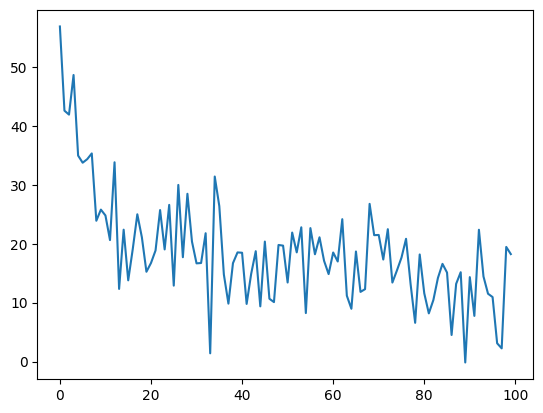

In [ ]:
plt.figure()
plt.plot(rbm.energy_loss)

In [ ]:
# from util import *
# from rbm import RestrictedBoltzmannMachine
# from dbn import DeepBeliefNet

image_size = [28, 28]
train_imgs,train_lbls,test_imgs,test_lbls = read_mnist(dim=image_size, n_train=60000, n_test=10000)
train_imgs, train_lbls, test_imgs, test_lbls = read_mnist(dim=image_size, n_train=3000, n_test=1000)

print ("\nStarting a Restricted Boltzmann Machine..")
n_iter = 101

rbm500 = RestrictedBoltzmannMachine(ndim_visible=image_size[0]*image_size[1],
                                  ndim_hidden=500,
                                  is_bottom=True,
                                  image_size=image_size,
                                  is_top=False,
                                  n_labels=10,
                                  batch_size=20,
                                  directory = "weights_500",
)


rbm500.cd1(visible_trainset=train_imgs, n_iterations=n_iter, test_set = test_imgs)

rbm200 = RestrictedBoltzmannMachine(ndim_visible=image_size[0]*image_size[1],
                                  ndim_hidden=200,
                                  is_bottom=True,
                                  image_size=image_size,
                                  is_top=False,
                                  n_labels=10,
                                  batch_size=20,
                                  directory = "weights_200",
)


rbm200.cd1(visible_trainset=train_imgs, n_iterations=n_iter, test_set = test_imgs)




Starting a Restricted Boltzmann Machine..
learning CD1
iteration=      0 recon_loss=0.1493
iteration=      0 Test recon_loss=0.1476
iteration=      2 recon_loss=0.1112
iteration=      2 Test recon_loss=0.1119
iteration=      4 recon_loss=0.0962
iteration=      4 Test recon_loss=0.0975
iteration=      6 recon_loss=0.0868
iteration=      6 Test recon_loss=0.0883
iteration=      8 recon_loss=0.0811
iteration=      8 Test recon_loss=0.0823
iteration=     10 recon_loss=0.0758
iteration=     10 Test recon_loss=0.0777
iteration=     12 recon_loss=0.0723
iteration=     12 Test recon_loss=0.0740
iteration=     14 recon_loss=0.0687
iteration=     14 Test recon_loss=0.0705
iteration=     16 recon_loss=0.0665
iteration=     16 Test recon_loss=0.0677
iteration=     18 recon_loss=0.0638
iteration=     18 Test recon_loss=0.0654
iteration=     20 recon_loss=0.0620
iteration=     20 Test recon_loss=0.0640
iteration=     22 recon_loss=0.0603
iteration=     22 Test recon_loss=0.0623
iteration=     24 re

[0.1683874844447583,
 0.12596351318958968,
 0.10842452259335116,
 0.09902013917331647,
 0.09286421847170245,
 0.08777907441407938,
 0.08399662143288687,
 0.0807470749476261,
 0.07839796030176771,
 0.07603554366844771,
 0.07387346050184775,
 0.07200930817425004,
 0.07023630063790215,
 0.06901726969219053,
 0.06723150705380185,
 0.06643622227322295,
 0.06532062603472755,
 0.06454087246663363,
 0.06335477135952412,
 0.06218824474887988,
 0.06173111189573862,
 0.06094549431537315,
 0.059771516390870014,
 0.059308097690056384,
 0.05852764550918402,
 0.058290343921882426,
 0.057395285898673154,
 0.05712680684038316,
 0.056415530663245665,
 0.056036517391270205,
 0.05535277889587204,
 0.05503194722987232,
 0.05439356854506508,
 0.05386499044715925,
 0.053820405946692386,
 0.05333749778342709,
 0.05281652772873856,
 0.052550683057536754,
 0.052196176254815665,
 0.05164138100338176,
 0.05152353219719261,
 0.0511074207526148,
 0.05075115157827839,
 0.05027442922266949,
 0.050156442027791535,
 0.

In [ ]:
loc = "trained_rbm"
name = "200_nodes"
savetofile_rbm(loc, name, rbm200)
name = "500_nodes"
savetofile_rbm(loc, name, rbm500)

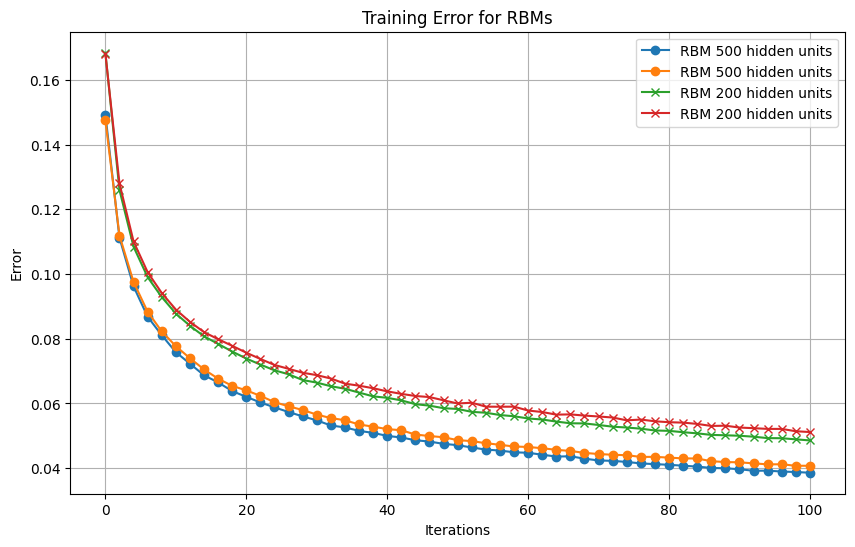

In [ ]:
plt.figure(figsize=(10, 6))
x = range(0, rbm500.print_period * len(rbm500.losses), rbm500.print_period)
plt.plot(x, rbm500.losses, label='RBM 500 hidden units', marker='o')
plt.plot(x, rbm500.losses_test, label='RBM 500 hidden units', marker='o')
x = range(0, rbm200.print_period * len(rbm200.losses), rbm200.print_period)
plt.plot(x, rbm200.losses, label='RBM 200 hidden units', marker='x')
plt.plot(x, rbm200.losses_test, label='RBM 200 hidden units', marker='x')

plt.title('Training Error for RBMs')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

# run.py - DBN (4.2)

In [52]:
image_size = [28, 28]
train_imgs,train_lbls,test_imgs,test_lbls = read_mnist(dim=image_size, n_train=60000, n_test=10000)
# train_imgs, train_lbls, test_imgs, test_lbls = read_mnist(dim=image_size, n_train=10000, n_test=10000)

dbn = DeepBeliefNet(sizes={"vis":image_size[0]*image_size[1], "hid":500, "pen":500, "top":2000, "lbl":10},
                    image_size=image_size,
                    n_labels=10,
                    batch_size=200,
                    directory="b"
)

''' greedy layer-wise training '''
# dbn.train_greedylayerwise(vis_trainset=np.zeros((1,)), lbl_trainset=np.zeros((1,)), n_iterations=200)
dbn.train_greedylayerwise(vis_trainset=train_imgs, lbl_trainset=train_lbls, n_iterations=20)


bottom_machine = dbn.rbm_stack['vis--hid']
viz_rf(weights=bottom_machine.weight_v_to_h[:,bottom_machine.rf["ids"]].reshape((bottom_machine.image_size[0],bottom_machine.image_size[1],-1)), it=0, grid=bottom_machine.rf["grid"], directory="a")


dbn.recognize(train_imgs, train_lbls)
dbn.recognize(test_imgs, test_lbls)

images = []
for digit in range(10):
    digit_1hot = np.zeros(shape=(1,10))
    digit_1hot[0,digit] = 1
    images.append(dbn.generate(digit_1hot, name="rbms"))

num_rows, num_cols = 2, 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 6))
pic_index = 0
for i in range(num_rows):
    for j in range(num_cols):
        ax = axes[i, j]
        data = images[pic_index].reshape((28,28))
        pic_index+=1
        ax.imshow(data, cmap='gray')
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_yticks([])  # Remove y-axis ticks

plt.tight_layout()
plt.show()

training vis--hid
learning CD1
iteration=      0 recon_loss=0.1360


ValueError: ignored